# Geometric Low-Rank Tensor Completion

**Published**: September 21, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**tensor-learning**](https://github.com/xinychen/tensor-learning/blob/master/content/LRTC.ipynb).

----------------

Geometric Low-rank Tensor Completion (GLTC) is an approach of reconstructing missing values within tensors. In particular, this approach could use the graphs as side information in form of regularizer.


## Motivation: Real-world graphs

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

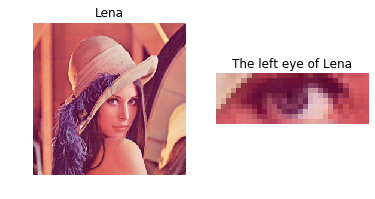

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../images/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye. The pixels of the left eye is apparent.

We start by importing the necessary dependencies. We will make use of `numpy`.

In [3]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

In [4]:
def non_negative(array):
    pos = np.where(array < 0)
    array[pos] = 0
    return array

In [5]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [6]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

In [7]:
def GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter):
    
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0))
    Y = np.zeros((dim1, dim2, dim3, dim0))
    B = np.zeros((dim1, dim2, dim3, dim0))
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D0 = np.zeros((dim1, dim1 - 1))
    for i in range(dim1 - 1):
        D0[i, i] = -1
        D0[i+1, i] = 1
    D = np.zeros((dim2, dim2 - 1))
    for i in range(dim2 - 1):
        D[i, i] = -1
        D[i+1, i] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            u, s, v = np.linalg.svd(ten2mat(X[:, :, :, k] + Y[:, :, :, k]/rho, k), full_matrices = 0)
            B[:, :, :, k] = mat2ten(np.matmul(np.matmul(u, np.diag(non_negative(s - 1/rho))), v), 
                                    np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = np.matmul(inv(alpha * np.matmul(D0, D0.T) + rho * np.eye(dim1)), 
                                 ten2mat(rho * B[:, :, :, k] - Y[:, :, :, k], k))
                X[:, :, :, k] = (np.multiply(1 - binary_tensor, mat2ten(var0, np.array([dim1, dim2, dim3]), k)) 
                                 + np.multiply(binary_tensor, sparse_tensor))
            elif k == 1:
                var0 = np.matmul(inv(alpha * np.matmul(D, D.T) + rho * np.eye(dim2)), 
                                 ten2mat(rho * B[:, :, :, k] - Y[:, :, :, k], k))
                X[:, :, :, k] = (np.multiply(1 - binary_tensor, mat2ten(var0, np.array([dim1, dim2, dim3]), k)) 
                                 + np.multiply(binary_tensor, sparse_tensor))
            elif k == 2:
                var0 = B[:, :, :, k] - Y[:, :, :, k]/rho
                X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                                 + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = Y[:, :, :, k] - rho * (B[:, :, :, k] - tensor_hat)
            Y[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

        rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
        if (iters + 1) % 100 == 0:
            print('Iter: {}'.format(iters + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()

    if maxiter >= 100:
        final_mape = np.sum(np.abs(dense_tensor[pos] - tensor_hat[pos])/dense_tensor[pos])/dense_tensor[pos].shape[0]
        final_rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
        print('Imputation MAPE: {:.6}'.format(final_mape))
        print('Imputation RMSE: {:.6}'.format(final_rmse))
        print()
    return tensor_hat

The shape of the image is (256, 256, 3).


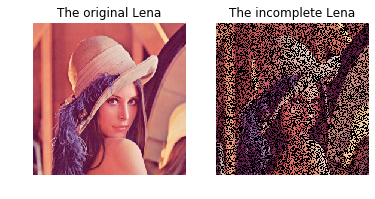

In [8]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena_in = lena.copy()
rate = 0.5
mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
for i in range(dim3):
    lena_in[:, :, i] = np.multiply(lena[:, :, i], mask)

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

In [9]:
dense_tensor = lena
sparse_tensor = lena_in

In [10]:
import time
start = time.time()
alpha = np.ones(3)/3
rho = 10
alpha = 0.1*rho
maxiter = 1000
tensor_hat1 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 10.7428

Iter: 200
RMSE: 9.75818

Iter: 300
RMSE: 9.74345

Iter: 400
RMSE: 9.74264

Iter: 500
RMSE: 9.74258

Iter: 600
RMSE: 9.74257

Iter: 700
RMSE: 9.74257

Iter: 800
RMSE: 9.74257

Iter: 900
RMSE: 9.74257

Iter: 1000
RMSE: 9.74257

Imputation MAPE: 0.068741
Imputation RMSE: 9.74257

Running time: 122 seconds


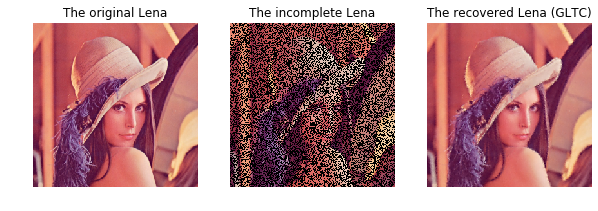

In [11]:
plt.subplots(1, 3, figsize=(10,25))

plt.subplot(1, 3, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.subplot(1, 3, 3)
lena_rec = np.round(tensor_hat1).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.imshow(lena_rec)
plt.title('The recovered Lena (GLTC)')
plt.axis('off')
plt.show()

In [40]:
import time
start = time.time()
alpha = np.ones(3)/3
rho = 0.001
alpha = 0*rho
maxiter = 1000
tensor_hat2 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 14.7013

Iter: 200
RMSE: 14.705

Iter: 300
RMSE: 14.7053

Iter: 400
RMSE: 14.7053

Iter: 500
RMSE: 14.7053

Iter: 600
RMSE: 14.7053

Iter: 700
RMSE: 14.7053

Iter: 800
RMSE: 14.7053

Iter: 900
RMSE: 14.7053

Iter: 1000
RMSE: 14.7053

Imputation MAPE: 0.116344
Imputation RMSE: 14.7053

Running time: 118 seconds


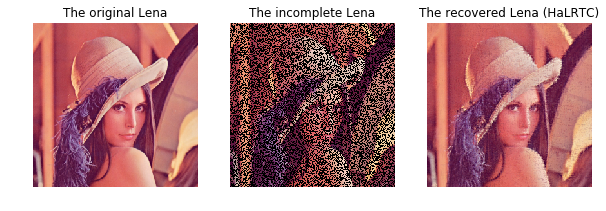

In [41]:
plt.subplots(1, 3, figsize=(10,25))

plt.subplot(1, 3, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

lena_rec = np.round(tensor_hat2).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.subplot(1, 3, 3)
plt.imshow(lena_rec)
plt.title('The recovered Lena (HaLRTC)')
plt.axis('off')
plt.show()

### Missing value scenario: completely random at the row direction

The shape of the image is (256, 256, 3).


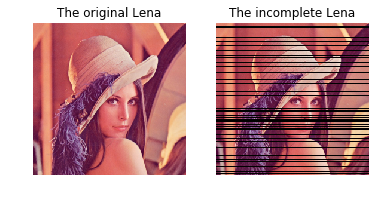

In [47]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena_in = lena.copy()
rate = 0.3
mask = np.round(np.random.rand(dim1) + 0.5 - rate)  # Generate a binary mask.
for i in range(dim2):
    for j in range(dim3):
        lena_in[:, i, j] = np.multiply(lena[:, i, j], mask)

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

The shape of the image is (256, 256, 3).


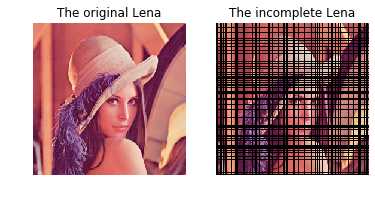

In [12]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena0 = lena.copy()
rate = 0.3
mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
for i in range(dim2):
    for j in range(dim3):
        lena0[:, i, j] = np.multiply(lena[:, i, j], mask_row)
lena_in = lena0.copy()
for i in range(dim1):
    for j in range(dim3):
        lena_in[i, :, j] = np.multiply(lena0[i, :, j], mask_column)

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

In [13]:
dense_tensor = lena
sparse_tensor = lena_in

In [14]:
import time
start = time.time()
alpha = np.ones(3)/3
rho = 1
alpha = 0.1*rho
maxiter = 1000
tensor_hat1 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 28.0427

Iter: 200
RMSE: 15.2778

Iter: 300
RMSE: 12.9469

Iter: 400
RMSE: 12.5969

Iter: 500
RMSE: 12.5887

Iter: 600
RMSE: 12.6216

Iter: 700
RMSE: 12.647

Iter: 800
RMSE: 12.662

Iter: 900
RMSE: 12.67

Iter: 1000
RMSE: 12.6742

Imputation MAPE: 0.0949073
Imputation RMSE: 12.6742

Running time: 122 seconds


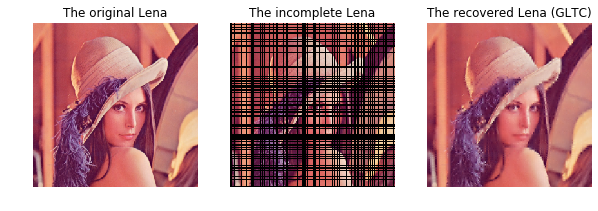

In [15]:
plt.subplots(1, 3, figsize=(10,25))

plt.subplot(1, 3, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.subplot(1, 3, 3)
lena_rec = np.round(tensor_hat1).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.imshow(lena_rec)
plt.title('The recovered Lena (GLTC)')
plt.axis('off')
plt.show()

In [16]:
import time
start = time.time()
alpha = np.ones(3)/3
rho = 0.001
alpha = 0*rho
maxiter = 1000
tensor_hat2 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 139.853

Iter: 200
RMSE: 139.853

Iter: 300
RMSE: 139.853

Iter: 400
RMSE: 139.853

Iter: 500
RMSE: 139.853

Iter: 600
RMSE: 139.853

Iter: 700
RMSE: 139.853

Iter: 800
RMSE: 139.853

Iter: 900
RMSE: 139.853

Iter: 1000
RMSE: 139.853

Imputation MAPE: 1.0
Imputation RMSE: 139.853

Running time: 110 seconds


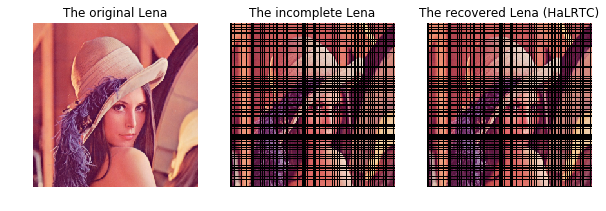

In [17]:
plt.subplots(1, 3, figsize=(10,25))

plt.subplot(1, 3, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

lena_rec = np.round(tensor_hat2).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.subplot(1, 3, 3)
plt.imshow(lena_rec)
plt.title('The recovered Lena (HaLRTC)')
plt.axis('off')
plt.show()